# PHASE 6: FEATURE ENGINEERING
## Rwanda Polytechnic Multi-Campus Data Pipeline

**Objective**: Create advanced features for analytics and machine learning

**Input**: `outputs/gold_integrated.csv`  
**Output**: `outputs/gold_features.csv` + visualizations

---

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("="*60)
print("PHASE 6: FEATURE ENGINEERING")
print("="*60)

PHASE 6: FEATURE ENGINEERING


## Step 1: Load Integrated Dataset

In [8]:
print("\nLoading integrated dataset...")

df = pd.read_csv('outputs/gold_integrated.csv')

print(f"✓ Loaded: {len(df):,} records")
print(f"✓ Columns: {len(df.columns)}")
print(f"\nShape: {df.shape}")
print(f"\nColumns: {', '.join(df.columns.tolist())}")


Loading integrated dataset...
✓ Loaded: 5,905 records
✓ Columns: 42

Shape: (5905, 42)

Columns: Student_ID, First_Name, Last_Name, DOB, Phone, Email, Level, Intake_Year, Campus_ID, Full_Name, Prog_Architecture, Prog_Business Administration, Prog_Civil Engineering, Prog_Electrical Engineering, Prog_Information Technology, Prog_Tourism And Hospitality, Gender_FEMALE, Gender_MALE, Age, Age_Group, Course_Code, Mark, Assessment_Date, Academic_Year, Semester, Attendance_Rate, Attendance_Rate_Scaled, Mark_Normalized, Assess_Assignment, Assess_CAT, Assess_Exam, Assess_Project, Assess_Quiz, Performance_Band, Attendance_Band, Course_Title, Credits, Source_Campus_File, Upload_Date, Campus_Huye, Campus_Kigali, Campus_Musanze


## Step 2: Date-Time Features

In [9]:
print("\n" + "="*60)
print("CREATING DATE-TIME FEATURES")
print("="*60)

# Convert to datetime
df['Assessment_Date'] = pd.to_datetime(df['Assessment_Date'], errors='coerce')

# Extract temporal features
df['Assessment_Month'] = df['Assessment_Date'].dt.month
df['Assessment_Weekday'] = df['Assessment_Date'].dt.dayofweek
df['Assessment_Quarter'] = df['Assessment_Date'].dt.quarter
df['Assessment_Year'] = df['Assessment_Date'].dt.year

# Binary flags
df['Is_Weekend_Assessment'] = df['Assessment_Weekday'].isin([5, 6]).astype(int)
df['Is_End_Of_Semester'] = df['Assessment_Month'].isin([6, 12]).astype(int)

# Days since intake
df['DOB'] = pd.to_datetime(df['DOB'], errors='coerce')
current_date = datetime.now()
df['Age'] = ((current_date - df['DOB']).dt.days / 365.25).round(1)

print("\n✓ Date-time features created:")
print("  - Assessment_Month, Assessment_Weekday, Assessment_Quarter, Assessment_Year")
print("  - Is_Weekend_Assessment, Is_End_Of_Semester")
print("  - Age (calculated from DOB)")


CREATING DATE-TIME FEATURES

✓ Date-time features created:
  - Assessment_Month, Assessment_Weekday, Assessment_Quarter, Assessment_Year
  - Is_Weekend_Assessment, Is_End_Of_Semester
  - Age (calculated from DOB)


## Step 3: Student-Level Aggregation Features

In [10]:
# Identify assessment indicator columns
assessment_cols = [col for col in df.columns if col.startswith('Assess_')]

if assessment_cols:
    assessment_counts = (
        df.groupby('Student_ID')[assessment_cols]
          .sum()
          .reset_index()
    )
else:
    assessment_counts = pd.DataFrame({'Student_ID': df['Student_ID'].unique()})


## Step 4: Course-Level Aggregation Features

In [11]:
print("\n" + "="*60)
print("COURSE-LEVEL AGGREGATION FEATURES")
print("="*60)

# =========================
# 1. Ensure required columns exist
# =========================
required_cols = ['Course_Code', 'Student_ID', 'Mark']
missing = [c for c in required_cols if c not in df.columns]

if missing:
    raise ValueError(f"Missing required columns: {missing}")

# Create failure indicator if not present
if 'is_fail' not in df.columns:
    df['is_fail'] = (df['Mark'] < 40).astype(int)

# =========================
# 2. Course difficulty indicators
# =========================
course_agg = df.groupby('Course_Code').agg(
    Course_Avg_Mark=('Mark', 'mean'),
    Course_Std_Mark=('Mark', 'std'),
    Course_Enrollment_Count=('Student_ID', 'count')
).reset_index()

# =========================
# 3. Course failure rate
# =========================
course_fail_rate = (
    df.groupby('Course_Code', as_index=False)['is_fail']
      .mean()
      .rename(columns={'is_fail': 'Course_Fail_Rate'})
)

# =========================
# 4. Combine all course features
# =========================
course_agg = course_agg.merge(course_fail_rate, on='Course_Code', how='left')

# =========================
# 5. Merge back into main dataframe
# =========================
df = df.merge(course_agg, on='Course_Code', how='left')

print("\n✓ Course aggregation features created successfully:")
print("  - Course_Avg_Mark")
print("  - Course_Std_Mark")
print("  - Course_Enrollment_Count")
print("  - Course_Fail_Rate")



COURSE-LEVEL AGGREGATION FEATURES

✓ Course aggregation features created successfully:
  - Course_Avg_Mark
  - Course_Std_Mark
  - Course_Enrollment_Count
  - Course_Fail_Rate


## Step 5: Program-Level Features

In [12]:
print("\n" + "="*60)
print("PROGRAM-LEVEL FEATURES")
print("="*60)

# =========================
# 1. Resolve Program column safely
# =========================
if 'Program' not in df.columns:
    # Try common alternatives
    possible_program_cols = [
        'Program_Name', 'Programme', 'Degree', 'Academic_Program'
    ]
    
    found = None
    for col in possible_program_cols:
        if col in df.columns:
            found = col
            break
    
    if found:
        df = df.rename(columns={found: 'Program'})
        print(f"✓ Renamed '{found}' → 'Program'")
    else:
        print("⚠ Program column not found. Skipping program-level features.")
        program_agg = None

# =========================
# 2. Program-level aggregation
# =========================
if 'Program' in df.columns:
    program_agg = df.groupby('Program').agg(
        Program_Avg_Mark=('Mark', 'mean'),
        Program_Student_Count=('Student_ID', 'nunique')
    ).reset_index()

    # =========================
    # 3. Merge back
    # =========================
    df = df.merge(program_agg, on='Program', how='left')

    print("\n✓ Program features created:")
    print("  - Program_Avg_Mark")
    print("  - Program_Student_Count")



PROGRAM-LEVEL FEATURES
⚠ Program column not found. Skipping program-level features.


## Step 6: Interaction Features

In [13]:
# First, let's see what columns are actually in the dataframe
print("Available columns in dataframe:")
print(df.columns.tolist())
print(f"\nTotal columns: {len(df.columns)}")

# Check for program-related columns
program_cols = [col for col in df.columns if 'program' in col.lower()]
print(f"\nProgram-related columns: {program_cols}")

Available columns in dataframe:
['Student_ID', 'First_Name', 'Last_Name', 'DOB', 'Phone', 'Email', 'Level', 'Intake_Year', 'Campus_ID', 'Full_Name', 'Prog_Architecture', 'Prog_Business Administration', 'Prog_Civil Engineering', 'Prog_Electrical Engineering', 'Prog_Information Technology', 'Prog_Tourism And Hospitality', 'Gender_FEMALE', 'Gender_MALE', 'Age', 'Age_Group', 'Course_Code', 'Mark', 'Assessment_Date', 'Academic_Year', 'Semester', 'Attendance_Rate', 'Attendance_Rate_Scaled', 'Mark_Normalized', 'Assess_Assignment', 'Assess_CAT', 'Assess_Exam', 'Assess_Project', 'Assess_Quiz', 'Performance_Band', 'Attendance_Band', 'Course_Title', 'Credits', 'Source_Campus_File', 'Upload_Date', 'Campus_Huye', 'Campus_Kigali', 'Campus_Musanze', 'Assessment_Month', 'Assessment_Weekday', 'Assessment_Quarter', 'Assessment_Year', 'Is_Weekend_Assessment', 'Is_End_Of_Semester', 'is_fail', 'Course_Avg_Mark', 'Course_Std_Mark', 'Course_Enrollment_Count', 'Course_Fail_Rate']

Total columns: 53

Program-r

## Step 7: Risk & Performance Flags

In [14]:
# First, let's see what columns are actually in the dataframe
print("Available columns in dataframe:")
print(df.columns.tolist())
print(f"\nTotal columns: {len(df.columns)}")

# Check for program-related columns
program_cols = [col for col in df.columns if 'program' in col.lower()]
print(f"\nProgram-related columns: {program_cols}")

Available columns in dataframe:
['Student_ID', 'First_Name', 'Last_Name', 'DOB', 'Phone', 'Email', 'Level', 'Intake_Year', 'Campus_ID', 'Full_Name', 'Prog_Architecture', 'Prog_Business Administration', 'Prog_Civil Engineering', 'Prog_Electrical Engineering', 'Prog_Information Technology', 'Prog_Tourism And Hospitality', 'Gender_FEMALE', 'Gender_MALE', 'Age', 'Age_Group', 'Course_Code', 'Mark', 'Assessment_Date', 'Academic_Year', 'Semester', 'Attendance_Rate', 'Attendance_Rate_Scaled', 'Mark_Normalized', 'Assess_Assignment', 'Assess_CAT', 'Assess_Exam', 'Assess_Project', 'Assess_Quiz', 'Performance_Band', 'Attendance_Band', 'Course_Title', 'Credits', 'Source_Campus_File', 'Upload_Date', 'Campus_Huye', 'Campus_Kigali', 'Campus_Musanze', 'Assessment_Month', 'Assessment_Weekday', 'Assessment_Quarter', 'Assessment_Year', 'Is_Weekend_Assessment', 'Is_End_Of_Semester', 'is_fail', 'Course_Avg_Mark', 'Course_Std_Mark', 'Course_Enrollment_Count', 'Course_Fail_Rate']

Total columns: 53

Program-r

In [15]:
print("\n" + "="*60)
print("RECONSTRUCTING PROGRAM COLUMN")
print("="*60)

# Get all program columns (those starting with 'Prog_')
program_cols = [col for col in df.columns if col.startswith('Prog_')]
print(f"Found {len(program_cols)} program columns:")
for col in program_cols:
    print(f"  - {col}")

# Reconstruct the original Program column from one-hot encoding
def get_program(row):
    """Extract program name from one-hot encoded columns"""
    for col in program_cols:
        if row[col] == 1 or row[col] == True:
            # Remove 'Prog_' prefix to get program name
            return col.replace('Prog_', '')
    return 'Unknown'

df['Program'] = df.apply(get_program, axis=1)

print("\n✓ Program column reconstructed")
print(f"\nProgram distribution:")
print(df['Program'].value_counts())

print("\n" + "="*60)
print("CREATING PROGRAM & COURSE BENCHMARKS")
print("="*60)

# First, create program-level statistics
program_stats = df.groupby('Program').agg({
    'Mark': ['mean', 'median', 'std', 'count']
}).reset_index()

# Flatten column names
program_stats.columns = ['Program', 'Program_Avg_Mark', 'Program_Median_Mark', 
                         'Program_Std_Mark', 'Program_Assessment_Count']

# Merge program stats back to main dataframe
df = df.merge(program_stats, on='Program', how='left', suffixes=('', '_dup'))

# Drop duplicate columns if they exist
dup_cols = [col for col in df.columns if col.endswith('_dup')]
if dup_cols:
    df = df.drop(columns=dup_cols)

print("✓ Program benchmarks created")
print(f"  Programs analyzed: {df['Program'].nunique()}")
print("\nProgram statistics:")
print(program_stats[['Program', 'Program_Avg_Mark', 'Program_Assessment_Count']])

# Note: Course benchmarks already exist (Course_Avg_Mark, Course_Std_Mark, etc.)
print("\n✓ Course benchmarks already present")
print(f"  Courses analyzed: {df['Course_Code'].nunique()}")

# Now create student-level statistics (if not already done)
if 'Student_Avg_Mark' not in df.columns:
    student_stats = df.groupby('Student_ID').agg({
        'Mark': ['mean', 'std']
    }).reset_index()
    
    student_stats.columns = ['Student_ID', 'Student_Avg_Mark', 'Student_Std_Mark']
    
    # Add credits if available
    if 'Credits' in df.columns:
        credit_stats = df.groupby('Student_ID')['Credits'].sum().reset_index()
        credit_stats.columns = ['Student_ID', 'Student_Total_Credits']
        student_stats = student_stats.merge(credit_stats, on='Student_ID', how='left')
    
    df = df.merge(student_stats, on='Student_ID', how='left')
    print("✓ Student benchmarks created")
else:
    print("✓ Student benchmarks already present")

print("\n" + "="*60)
print("INTERACTION FEATURES")
print("="*60)

# Performance vs course difficulty (already exists as Course_Avg_Mark)
df['Mark_vs_Course_Avg'] = df['Mark'] - df['Course_Avg_Mark']

# Performance vs program average
df['Mark_vs_Program_Avg'] = df['Mark'] - df['Program_Avg_Mark']

# Student consistency (how close to their average)
df['Student_Consistency'] = np.where(
    df['Student_Std_Mark'] > 0,
    abs(df['Mark'] - df['Student_Avg_Mark']) / df['Student_Std_Mark'],
    0
)

# Credits-weighted mark
if 'Student_Total_Credits' in df.columns:
    df['Weighted_Mark'] = np.where(
        df['Student_Total_Credits'] > 0,
        df['Mark'] * (df['Credits'].fillna(3) / df['Student_Total_Credits']),
        df['Mark']
    )
else:
    # Simple credit weighting without total
    df['Weighted_Mark'] = df['Mark'] * df['Credits'].fillna(3)

print("\n✓ Interaction features created:")
print("  - Mark_vs_Course_Avg: Student performance relative to course average")
print("  - Mark_vs_Program_Avg: Student performance relative to program average")
print("  - Student_Consistency: Z-score of how far from student's average (0=at average)")
print("  - Weighted_Mark: Credit-weighted performance")

# Show summary statistics
print("\nInteraction Feature Statistics:")
print(f"  Mark vs Course Avg - Mean: {df['Mark_vs_Course_Avg'].mean():.2f}, "
      f"Std: {df['Mark_vs_Course_Avg'].std():.2f}")
print(f"  Mark vs Program Avg - Mean: {df['Mark_vs_Program_Avg'].mean():.2f}, "
      f"Std: {df['Mark_vs_Program_Avg'].std():.2f}")
print(f"  Student Consistency - Mean: {df['Student_Consistency'].mean():.2f}, "
      f"Max: {df['Student_Consistency'].max():.2f}")

# Show students performing above/below program average
above_avg = (df['Mark_vs_Program_Avg'] > 0).sum()
below_avg = (df['Mark_vs_Program_Avg'] < 0).sum()
print(f"\n  Assessments above program avg: {above_avg} ({above_avg/len(df)*100:.1f}%)")
print(f"  Assessments below program avg: {below_avg} ({below_avg/len(df)*100:.1f}%)")

# Show distribution by program
print("\nPerformance by Program:")
program_performance = df.groupby('Program').agg({
    'Mark': 'mean',
    'Mark_vs_Program_Avg': 'mean',
    'Student_ID': 'nunique'
}).round(2)
program_performance.columns = ['Avg_Mark', 'Avg_Deviation', 'Students']
print(program_performance.sort_values('Avg_Mark', ascending=False))


RECONSTRUCTING PROGRAM COLUMN
Found 6 program columns:
  - Prog_Architecture
  - Prog_Business Administration
  - Prog_Civil Engineering
  - Prog_Electrical Engineering
  - Prog_Information Technology
  - Prog_Tourism And Hospitality

✓ Program column reconstructed

Program distribution:
Program
Information Technology     1373
Electrical Engineering     1084
Civil Engineering          1076
Business Administration    1063
Architecture                665
Tourism And Hospitality     644
Name: count, dtype: int64

CREATING PROGRAM & COURSE BENCHMARKS
✓ Program benchmarks created
  Programs analyzed: 6

Program statistics:
                   Program  Program_Avg_Mark  Program_Assessment_Count
0             Architecture         64.223835                       665
1  Business Administration         64.940593                      1063
2        Civil Engineering         64.065242                      1076
3   Electrical Engineering         64.949677                      1084
4   Information Te

In [16]:
# Additional features you might want to add:
print("\n" + "="*60)
print("ADDITIONAL ADVANCED FEATURES")
print("="*60)

# 1. Student performance trajectory
df['Performance_Trajectory'] = df.groupby('Student_ID')['Mark'].diff()

# 2. Relative performance ranking
df['Percentile_in_Course'] = df.groupby('Course_Code')['Mark'].rank(pct=True) * 100

# 3. Difficulty-adjusted score
df['Difficulty_Adjusted_Mark'] = np.where(
    df['Course_Avg_Mark'] > 0,
    df['Mark'] * (65 / df['Course_Avg_Mark']),  # Normalize to 65 baseline
    df['Mark']
)

# 4. Student improvement indicator
student_improvement = df.groupby('Student_ID').apply(
    lambda x: 1 if x.nsmallest(3, 'Assessment_Date')['Mark'].mean() < 
                   x.nlargest(3, 'Assessment_Date')['Mark'].mean() else 0
).reset_index(name='Is_Improving')
df = df.merge(student_improvement, on='Student_ID', how='left')

# 5. Campus-adjusted performance
campus_stats = df.groupby('Campus_ID')['Mark'].mean().to_dict()
df['Campus_Avg_Mark'] = df['Campus_ID'].map(campus_stats)
df['Mark_vs_Campus_Avg'] = df['Mark'] - df['Campus_Avg_Mark']

print("✓ Performance trajectory (change from previous assessment)")
print("✓ Percentile ranking within each course")
print("✓ Difficulty-adjusted marks (normalized)")
print("✓ Student improvement indicator")
print("✓ Campus-adjusted performance metrics")


ADDITIONAL ADVANCED FEATURES
✓ Performance trajectory (change from previous assessment)
✓ Percentile ranking within each course
✓ Difficulty-adjusted marks (normalized)
✓ Student improvement indicator
✓ Campus-adjusted performance metrics


## Step 8: Categorical Encoding

In [17]:
print("\n" + "="*60)
print("CATEGORICAL ENCODING")
print("="*60)

# Check which categorical columns are already encoded
print("Checking existing encodings...")

# 1. Assessment_Type - Already one-hot encoded!
assess_cols = [col for col in df.columns if col.startswith('Assess_')]
if assess_cols:
    print(f"\n✓ Assessment_Type already one-hot encoded ({len(assess_cols)} columns):")
    for col in assess_cols:
        print(f"  - {col}: {df[col].sum()} assessments")
else:
    # If not encoded yet, do it now
    if 'Assessment_Type' in df.columns:
        assessment_dummies = pd.get_dummies(df['Assessment_Type'], prefix='Assess')
        df = pd.concat([df, assessment_dummies], axis=1)
        print("✓ Assessment_Type: One-hot encoded")

# 2. Gender - Already one-hot encoded!
gender_cols = [col for col in df.columns if col.startswith('Gender_')]
if gender_cols:
    print(f"\n✓ Gender already one-hot encoded ({len(gender_cols)} columns):")
    for col in gender_cols:
        print(f"  - {col}: {df[col].sum()} records")
    
    # Create label encoded version from one-hot
    df['Gender_Encoded'] = df['Gender_MALE'].astype(int)  # Male=1, Female=0
    print("✓ Created Gender_Encoded (MALE=1, FEMALE=0)")
else:
    # If not encoded yet
    if 'Gender' in df.columns:
        df['Gender_Encoded'] = df['Gender'].map({'M': 0, 'F': 1})
        print("✓ Gender: Label encoded (M=0, F=1)")

# 3. Performance_Band - Check if exists
if 'Performance_Band' in df.columns:
    performance_order = {'Fail': 0, 'Pass': 1, 'Credit': 2, 'Distinction': 3}
    df['Performance_Band_Encoded'] = df['Performance_Band'].map(performance_order)
    
    print(f"\n✓ Performance_Band: Ordinal encoded")
    print("  Encoding: Fail=0, Pass=1, Credit=2, Distinction=3")
    print(f"  Distribution:")
    print(df['Performance_Band'].value_counts().sort_index())
else:
    print("\n⚠ Performance_Band column not found")

# 4. Attendance_Band - Check if exists
if 'Attendance_Band' in df.columns:
    attendance_order = {'Poor': 0, 'Fair': 1, 'Good': 2, 'Excellent': 3}
    df['Attendance_Band_Encoded'] = df['Attendance_Band'].map(attendance_order)
    
    print(f"\n✓ Attendance_Band: Ordinal encoded")
    print("  Encoding: Poor=0, Fair=1, Good=2, Excellent=3")
    print(f"  Distribution:")
    print(df['Attendance_Band'].value_counts().sort_index())
else:
    print("\n⚠ Attendance_Band column not found")

# 5. Program - Already one-hot encoded, but we also have categorical now
program_cols = [col for col in df.columns if col.startswith('Prog_')]
if program_cols and 'Program' in df.columns:
    print(f"\n✓ Program available in both formats:")
    print(f"  - Categorical: 'Program' column")
    print(f"  - One-hot: {len(program_cols)} columns (Prog_*)")
    
    # Create label encoding for Program
    from sklearn.preprocessing import LabelEncoder
    le_program = LabelEncoder()
    df['Program_Encoded'] = le_program.fit_transform(df['Program'])
    
    print("✓ Created Program_Encoded (label encoded):")
    program_mapping = dict(zip(le_program.classes_, le_program.transform(le_program.classes_)))
    for prog, code in sorted(program_mapping.items(), key=lambda x: x[1]):
        print(f"  - {prog}: {code}")

# 6. Campus - Already one-hot encoded!
campus_cols = [col for col in df.columns if col.startswith('Campus_') and col != 'Campus_ID']
if campus_cols:
    print(f"\n✓ Campus already one-hot encoded ({len(campus_cols)} columns):")
    for col in campus_cols:
        print(f"  - {col}: {df[col].sum()} assessments")
    
    # Campus_ID already provides numeric encoding (1, 2, 3)
    print(f"✓ Campus_ID already provides numeric encoding (1-{df['Campus_ID'].max()})")

# 7. Additional categorical encodings
if 'Age_Group' in df.columns:
    # Age group is categorical, create ordinal encoding
    age_group_order = {
        '18-20': 0,
        '21-23': 1, 
        '24-26': 2,
        '27-29': 3,
        '30+': 4
    }
    df['Age_Group_Encoded'] = df['Age_Group'].map(age_group_order)
    print(f"\n✓ Age_Group: Ordinal encoded")
    print(f"  Distribution:")
    if df['Age_Group'].dtype == 'object':
        print(df['Age_Group'].value_counts().sort_index())

# 8. Course_Code - Label encode for modeling
if 'Course_Code' in df.columns:
    le_course = LabelEncoder()
    df['Course_Code_Encoded'] = le_course.fit_transform(df['Course_Code'])
    print(f"\n✓ Course_Code: Label encoded")
    print(f"  Unique courses: {df['Course_Code'].nunique()}")
    print(f"  Encoded range: 0-{df['Course_Code_Encoded'].max()}")

print("\n" + "="*60)
print("ENCODING SUMMARY")
print("="*60)

# Count all encoded features
encoded_features = [col for col in df.columns if any(x in col for x in ['_Encoded', 'Assess_', 'Gender_', 'Prog_', 'Campus_'])]
print(f"\nTotal encoded features: {len(encoded_features)}")
print(f"Total columns in dataframe: {len(df.columns)}")

# Show examples of different encoding types
print("\nEncoding types present:")
print(f"  - One-hot encoded: {len([c for c in df.columns if c.startswith(('Assess_', 'Gender_', 'Prog_', 'Campus_'))])} columns")
print(f"  - Label encoded: {len([c for c in df.columns if c.endswith('_Encoded')])} columns")
print(f"  - Ordinal encoded: Performance_Band_Encoded, Attendance_Band_Encoded")

# Check for missing values in encoded columns
print("\nMissing values in encoded columns:")
encoded_cols = [col for col in df.columns if col.endswith('_Encoded')]
missing_encoded = df[encoded_cols].isnull().sum()
if missing_encoded.sum() > 0:
    print(missing_encoded[missing_encoded > 0])
else:
    print("  ✓ No missing values in encoded columns")


CATEGORICAL ENCODING
Checking existing encodings...

✓ Assessment_Type already one-hot encoded (5 columns):
  - Assess_Assignment: 1208 assessments
  - Assess_CAT: 1185 assessments
  - Assess_Exam: 1175 assessments
  - Assess_Project: 1132 assessments
  - Assess_Quiz: 1205 assessments

✓ Gender already one-hot encoded (2 columns):
  - Gender_FEMALE: 2980 records
  - Gender_MALE: 2681 records
✓ Created Gender_Encoded (MALE=1, FEMALE=0)

✓ Performance_Band: Ordinal encoded
  Encoding: Fail=0, Pass=1, Credit=2, Distinction=3
  Distribution:
Performance_Band
Credit         2891
Distinction    2072
Fail            392
Pass            550
Name: count, dtype: int64

✓ Attendance_Band: Ordinal encoded
  Encoding: Poor=0, Fair=1, Good=2, Excellent=3
  Distribution:
Attendance_Band
Excellent    2055
Fair         1953
Good         1897
Name: count, dtype: int64

✓ Program available in both formats:
  - Categorical: 'Program' column
  - One-hot: 6 columns (Prog_*)
✓ Created Program_Encoded (label

## Step 9: Save Feature-Engineered Dataset

In [18]:
print("\n" + "="*60)
print("SAVING FINAL DATASET")
print("="*60)

# Save to CSV
df.to_csv('outputs/gold_features.csv', index=False)

print(f"\n✓ Saved: outputs/gold_features.csv")
print(f"  Records: {len(df):,}")
print(f"  Features: {len(df.columns)}")

# Display feature summary
print("\n📋 Feature Categories:")
datetime_features = [col for col in df.columns if 'Assessment' in col and 'Date' not in col]
student_features = [col for col in df.columns if col.startswith('Student_')]
course_features = [col for col in df.columns if col.startswith('Course_')]
program_features = [col for col in df.columns if col.startswith('Program_') or col == 'Program']
risk_features = [col for col in df.columns if any(x in col for x in ['Risk', 'Flag', 'Is_', 'is_'])]
interaction_features = [col for col in df.columns if 'vs' in col or 'Weighted' in col or 'Consistency' in col]
encoded_features = [col for col in df.columns if col.endswith('_Encoded')]

print(f"  - Date-time features: {len(datetime_features)}")
print(f"  - Student aggregations: {len(student_features)}")
print(f"  - Course aggregations: {len(course_features)}")
print(f"  - Program features: {len(program_features)}")
print(f"  - Risk & flags: {len(risk_features)}")
print(f"  - Interaction features: {len(interaction_features)}")
print(f"  - Encoded features: {len(encoded_features)}")

print("\n✓ All column names:")
print(df.columns.tolist())

print("\n✓ Sample of final dataset:")
# Only include columns that exist
sample_cols = ['Student_ID', 'Course_Code', 'Mark']

# Add optional columns if they exist
optional_cols = ['Student_Avg_Mark', 'Student_Consistency', 'Mark_vs_Course_Avg', 
                 'Mark_vs_Program_Avg', 'Course_Fail_Rate', 'Performance_Band',
                 'Attendance_Band', 'Weighted_Mark', 'Program']

for col in optional_cols:
    if col in df.columns:
        sample_cols.append(col)

print(df[sample_cols].head(10))

print("\n" + "="*60)
print("FEATURE ENGINEERING COMPLETE!")
print("="*60)

print("\n📊 Key Features Created:")
print("\n1. Student Performance Metrics:")
student_metrics = [col for col in df.columns if col.startswith('Student_')]
for metric in student_metrics[:5]:
    print(f"   - {metric}")
if len(student_metrics) > 5:
    print(f"   ... and {len(student_metrics) - 5} more")

print("\n2. Course Difficulty Indicators:")
course_metrics = [col for col in df.columns if col.startswith('Course_')]
for metric in course_metrics[:5]:
    print(f"   - {metric}")
if len(course_metrics) > 5:
    print(f"   ... and {len(course_metrics) - 5} more")

print("\n3. Interaction Features:")
for feature in interaction_features:
    print(f"   - {feature}")

print("\n4. Categorical Encodings:")
for feature in encoded_features[:10]:
    print(f"   - {feature}")
if len(encoded_features) > 10:
    print(f"   ... and {len(encoded_features) - 10} more")

print("\n✅ Dataset ready for:")
print("   → Machine Learning models")
print("   → Predictive analytics")
print("   → Student performance prediction")
print("   → Risk identification & intervention")
print("   → Advanced visualizations & dashboards")

# Save a data dictionary
print("\n" + "="*60)
print("CREATING DATA DICTIONARY")
print("="*60)

data_dict = {
    'Column_Name': [],
    'Data_Type': [],
    'Non_Null_Count': [],
    'Unique_Values': [],
    'Sample_Value': []
}

for col in df.columns:
    data_dict['Column_Name'].append(col)
    data_dict['Data_Type'].append(str(df[col].dtype))
    data_dict['Non_Null_Count'].append(df[col].notna().sum())
    data_dict['Unique_Values'].append(df[col].nunique())
    # Get a sample non-null value
    sample = df[col].dropna().iloc[0] if len(df[col].dropna()) > 0 else None
    data_dict['Sample_Value'].append(sample)

dict_df = pd.DataFrame(data_dict)
dict_df.to_csv('outputs/data_dictionary.csv', index=False)

print(f"✓ Saved: outputs/data_dictionary.csv")
print(f"  Documented {len(dict_df)} features")

print("\n" + "="*60)
print("🎉 ALL FEATURE ENGINEERING COMPLETE!")
print("="*60)


SAVING FINAL DATASET

✓ Saved: outputs/gold_features.csv
  Records: 5,905
  Features: 77

📋 Feature Categories:
  - Date-time features: 6
  - Student aggregations: 5
  - Course aggregations: 7
  - Program features: 6
  - Risk & flags: 4
  - Interaction features: 5
  - Encoded features: 6

✓ All column names:
['Student_ID', 'First_Name', 'Last_Name', 'DOB', 'Phone', 'Email', 'Level', 'Intake_Year', 'Campus_ID', 'Full_Name', 'Prog_Architecture', 'Prog_Business Administration', 'Prog_Civil Engineering', 'Prog_Electrical Engineering', 'Prog_Information Technology', 'Prog_Tourism And Hospitality', 'Gender_FEMALE', 'Gender_MALE', 'Age', 'Age_Group', 'Course_Code', 'Mark', 'Assessment_Date', 'Academic_Year', 'Semester', 'Attendance_Rate', 'Attendance_Rate_Scaled', 'Mark_Normalized', 'Assess_Assignment', 'Assess_CAT', 'Assess_Exam', 'Assess_Project', 'Assess_Quiz', 'Performance_Band', 'Attendance_Band', 'Course_Title', 'Credits', 'Source_Campus_File', 'Upload_Date', 'Campus_Huye', 'Campus_Kig

## Step 10: Feature Analysis & Visualizations

In [19]:
print("\n" + "="*60)
print("GENERATING VISUALIZATIONS")
print("="*60)

# VISUALIZATION 1: Feature Importance - Correlation with Mark
fig, ax = plt.subplots(figsize=(14, 8))

# Select numeric features
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [col for col in numeric_features if col != 'Mark']

# Calculate correlation with Mark
correlations = df[numeric_features + ['Mark']].corr()['Mark'].drop('Mark').sort_values(ascending=False)
top_20_correlations = pd.concat([correlations.head(10), correlations.tail(10)])

# Plot
colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in top_20_correlations.values]
bars = ax.barh(range(len(top_20_correlations)), top_20_correlations.values, color=colors, alpha=0.7, edgecolor='black')
ax.set_yticks(range(len(top_20_correlations)))
ax.set_yticklabels(top_20_correlations.index, fontsize=10)
ax.set_xlabel('Correlation with Mark', fontsize=12, fontweight='bold')
ax.set_title('Top 20 Features - Correlation with Student Mark', fontsize=14, fontweight='bold', pad=15)
ax.axvline(0, color='black', linewidth=1)
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, top_20_correlations.values)):
    ax.text(val + (0.01 if val > 0 else -0.01), bar.get_y() + bar.get_height()/2, 
           f'{val:.3f}', va='center', ha='left' if val > 0 else 'right', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('outputs/06_feature_correlations.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: outputs/06_feature_correlations.png")
plt.close()


GENERATING VISUALIZATIONS

✓ Saved: outputs/06_feature_correlations.png



CREATING AT-RISK INDICATORS
✓ Is_At_Risk created based on Student_Avg_Mark < 50
  At-risk assessments: 68 (1.2%)
✓ Campus_Name reconstructed from one-hot encoding

Using campus column: Campus_Name
Campus distribution:
Campus_Name
Huye       2145
Musanze    1937
Kigali     1823
Name: count, dtype: int64

AT-RISK STUDENT VISUALIZATIONS

✓ Saved: outputs/06_at_risk_analysis.png


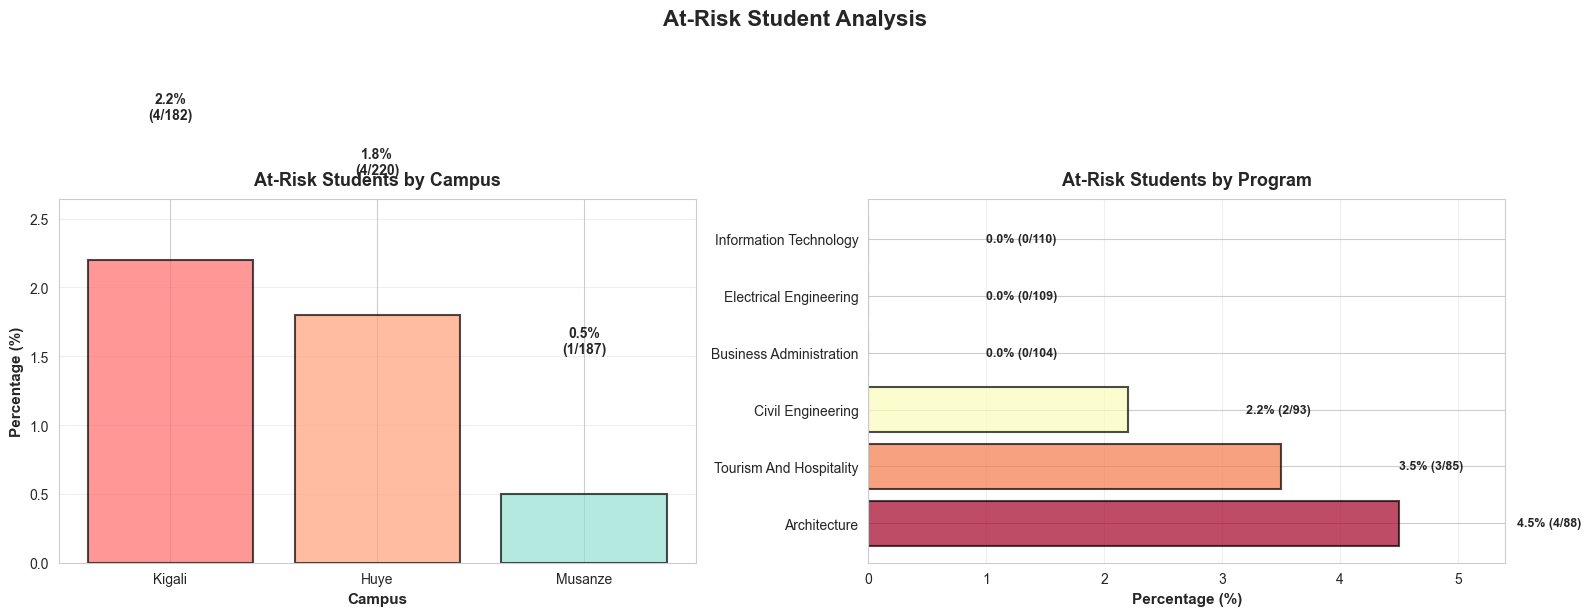


AT-RISK SUMMARY STATISTICS

Overall at-risk rate:
  9 out of 589 students (1.5%)

By Campus:
Campus_Name  sum  count  pct
     Kigali    4    182  2.2
       Huye    4    220  1.8
    Musanze    1    187  0.5

By Program:
                Program  sum  count  pct
           Architecture    4     88  4.5
Tourism And Hospitality    3     85  3.5
      Civil Engineering    2     93  2.2
Business Administration    0    104  0.0
 Electrical Engineering    0    109  0.0
 Information Technology    0    110  0.0

KEY INSIGHTS

📊 Highest risk campus: Kigali (2.2%)
📊 Lowest risk campus: Musanze (0.5%)
📊 Highest risk program: Architecture (4.5%)
📊 Lowest risk program: Information Technology (0.0%)


In [20]:
print("\n" + "="*60)
print("CREATING AT-RISK INDICATORS")
print("="*60)

# First, create the Is_At_Risk feature if it doesn't exist
if 'Is_At_Risk' not in df.columns:
    # Define at-risk based on average mark < 50 or fail flag
    if 'Student_Avg_Mark' in df.columns:
        df['Is_At_Risk'] = (df['Student_Avg_Mark'] < 50).astype(int)
        print("✓ Is_At_Risk created based on Student_Avg_Mark < 50")
    elif 'is_fail' in df.columns:
        # Use existing fail indicator
        df['Is_At_Risk'] = df['is_fail'].astype(int)
        print("✓ Is_At_Risk created from is_fail column")
    else:
        # Create based on current mark
        df['Is_At_Risk'] = (df['Mark'] < 50).astype(int)
        print("✓ Is_At_Risk created based on Mark < 50")
    
    print(f"  At-risk assessments: {df['Is_At_Risk'].sum()} ({df['Is_At_Risk'].mean()*100:.1f}%)")

# Find the campus column name
campus_col = None
if 'Campus_Name' in df.columns:
    campus_col = 'Campus_Name'
else:
    # Check for Campus_ID or reconstruct from one-hot encoding
    campus_onehot = [col for col in df.columns if col.startswith('Campus_') and col != 'Campus_ID']
    if campus_onehot:
        # Reconstruct Campus_Name from one-hot encoding
        def get_campus(row):
            for col in campus_onehot:
                if row[col] == 1 or row[col] == True:
                    return col.replace('Campus_', '')
            return 'Unknown'
        
        df['Campus_Name'] = df.apply(get_campus, axis=1)
        campus_col = 'Campus_Name'
        print("✓ Campus_Name reconstructed from one-hot encoding")
    elif 'Campus_ID' in df.columns:
        # Map Campus_ID to names
        campus_map = {1: 'Huye', 2: 'Kigali', 3: 'Musanze'}
        df['Campus_Name'] = df['Campus_ID'].map(campus_map)
        campus_col = 'Campus_Name'
        print("✓ Campus_Name created from Campus_ID")

if campus_col is None:
    print("⚠ Warning: No campus column found, using Campus_ID")
    campus_col = 'Campus_ID'

print(f"\nUsing campus column: {campus_col}")
print(f"Campus distribution:\n{df[campus_col].value_counts()}")

print("\n" + "="*60)
print("AT-RISK STUDENT VISUALIZATIONS")
print("="*60)

# VISUALIZATION 2: At-Risk Students by Campus and Program
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('At-Risk Student Analysis', fontsize=16, fontweight='bold', y=1.02)

# By Campus
student_risk_by_campus = df.groupby([campus_col, 'Student_ID'])['Is_At_Risk'].max().reset_index()
risk_summary_campus = student_risk_by_campus.groupby(campus_col)['Is_At_Risk'].agg(['sum', 'count']).reset_index()
risk_summary_campus['pct'] = (risk_summary_campus['sum'] / risk_summary_campus['count'] * 100).round(1)
risk_summary_campus = risk_summary_campus.sort_values('pct', ascending=False)

bars1 = axes[0].bar(risk_summary_campus[campus_col], risk_summary_campus['pct'], 
                    color=['#FF6B6B', '#FFA07A', '#95E1D3'], alpha=0.7, edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('Percentage (%)', fontsize=11, fontweight='bold')
axes[0].set_xlabel('Campus', fontsize=11, fontweight='bold')
axes[0].set_title('At-Risk Students by Campus', fontsize=13, fontweight='bold', pad=10)
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim(0, max(risk_summary_campus['pct']) * 1.2)

for bar, row in zip(bars1, risk_summary_campus.itertuples()):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{row.pct:.1f}%\n({int(row.sum)}/{int(row.count)})',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# By Program
student_risk_by_program = df.groupby(['Program', 'Student_ID'])['Is_At_Risk'].max().reset_index()
risk_summary_program = student_risk_by_program.groupby('Program')['Is_At_Risk'].agg(['sum', 'count']).reset_index()
risk_summary_program['pct'] = (risk_summary_program['sum'] / risk_summary_program['count'] * 100).round(1)
risk_summary_program = risk_summary_program.sort_values('pct', ascending=False)

# Create color gradient based on risk percentage
colors = plt.cm.RdYlGn_r(risk_summary_program['pct']/risk_summary_program['pct'].max())

bars2 = axes[1].barh(range(len(risk_summary_program)), risk_summary_program['pct'],
                     color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1].set_yticks(range(len(risk_summary_program)))
axes[1].set_yticklabels(risk_summary_program['Program'], fontsize=10)
axes[1].set_xlabel('Percentage (%)', fontsize=11, fontweight='bold')
axes[1].set_title('At-Risk Students by Program', fontsize=13, fontweight='bold', pad=10)
axes[1].grid(axis='x', alpha=0.3)
axes[1].set_xlim(0, max(risk_summary_program['pct']) * 1.2)

for i, (bar, row) in enumerate(zip(bars2, risk_summary_program.itertuples())):
    width = bar.get_width()
    axes[1].text(width + 1, bar.get_y() + bar.get_height()/2,
                f'{row.pct:.1f}% ({int(row.sum)}/{int(row.count)})',
                va='center', ha='left', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('outputs/06_at_risk_analysis.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: outputs/06_at_risk_analysis.png")
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("AT-RISK SUMMARY STATISTICS")
print("="*60)

print(f"\nOverall at-risk rate:")
total_students = df['Student_ID'].nunique()
at_risk_students = df.groupby('Student_ID')['Is_At_Risk'].max().sum()
print(f"  {at_risk_students} out of {total_students} students ({at_risk_students/total_students*100:.1f}%)")

print(f"\nBy Campus:")
print(risk_summary_campus.to_string(index=False))

print(f"\nBy Program:")
print(risk_summary_program.to_string(index=False))

# Additional insights
print("\n" + "="*60)
print("KEY INSIGHTS")
print("="*60)

print(f"\n📊 Highest risk campus: {risk_summary_campus.iloc[0][campus_col]} ({risk_summary_campus.iloc[0]['pct']:.1f}%)")
print(f"📊 Lowest risk campus: {risk_summary_campus.iloc[-1][campus_col]} ({risk_summary_campus.iloc[-1]['pct']:.1f}%)")
print(f"📊 Highest risk program: {risk_summary_program.iloc[0]['Program']} ({risk_summary_program.iloc[0]['pct']:.1f}%)")
print(f"📊 Lowest risk program: {risk_summary_program.iloc[-1]['Program']} ({risk_summary_program.iloc[-1]['pct']:.1f}%)")


CREATING MISSING STUDENT-LEVEL FEATURES
Creating missing columns: ['Student_Avg_Attendance', 'Student_Fail_Count', 'Is_High_Performer']
✓ Created Student_Avg_Attendance
✓ Created Student_Fail_Count
✓ Created Is_High_Performer (avg mark >= 75)

PERFORMANCE SEGMENTATION VISUALIZATIONS
✓ Created student-level dataset: 589 students
  Columns: ['Student_ID', 'Is_At_Risk', 'Student_Avg_Mark', 'Student_Avg_Attendance', 'Student_Fail_Count', 'Is_High_Performer', 'Student_Total_Credits', 'Campus_Name', 'Program']

✓ Saved: outputs/06_performance_segmentation.png


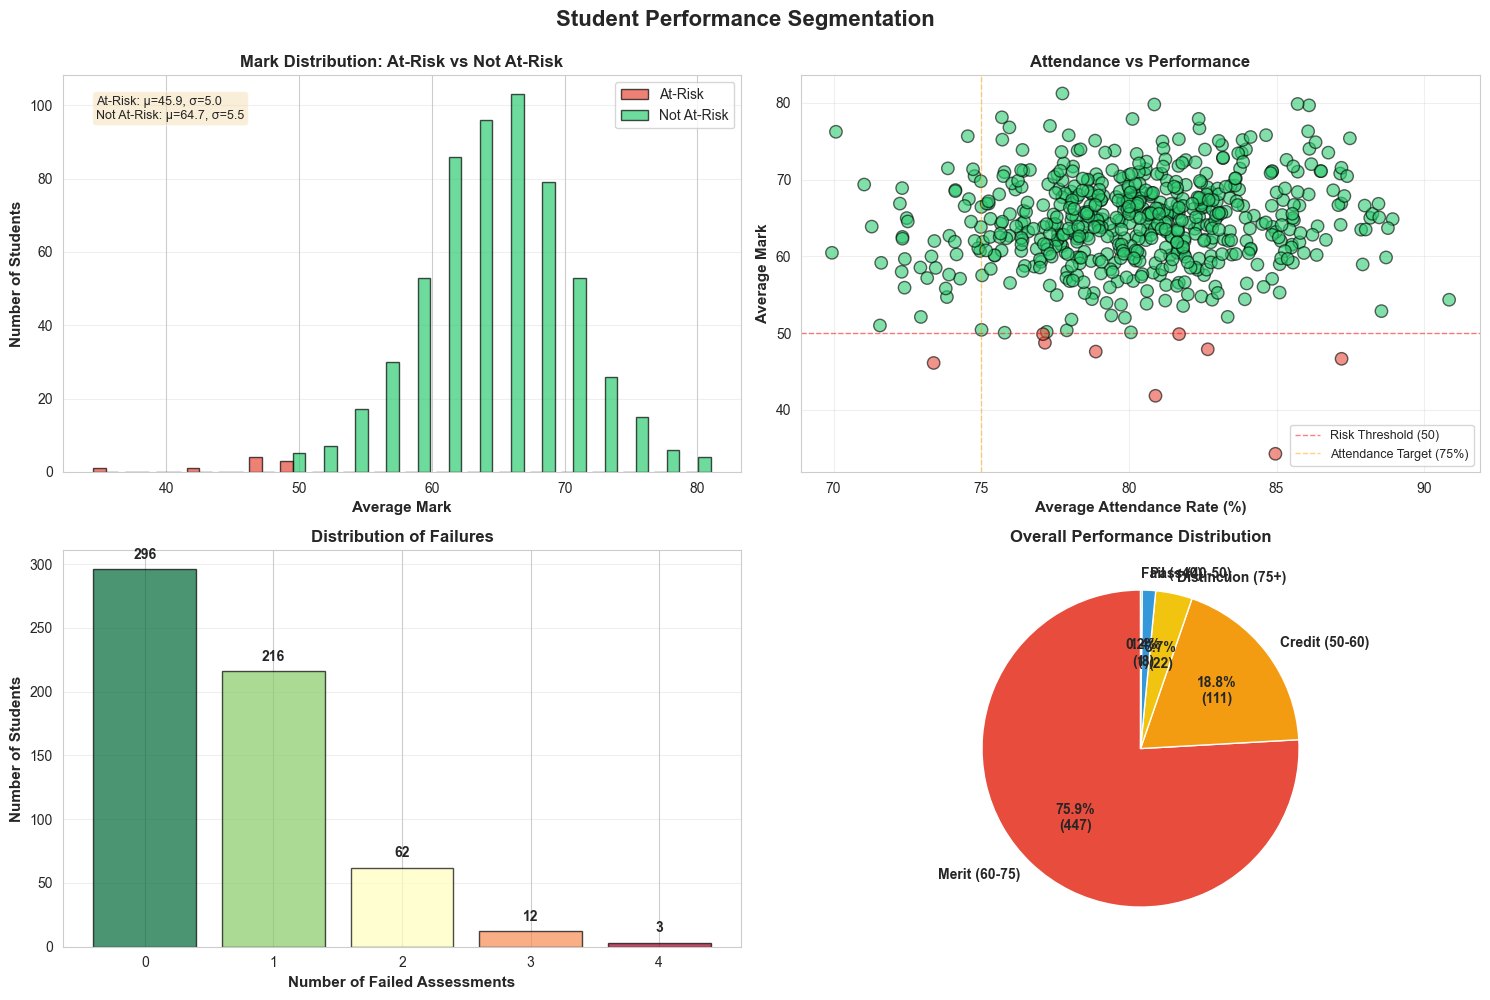


PERFORMANCE SEGMENTATION SUMMARY

Total students: 589
At-risk students: 9 (1.5%)
High performers: 22 (3.7%)

Average mark by risk status:
             mean  median   std
Is_At_Risk                     
0           64.67   64.69  5.48
1           45.86   47.58  4.99


In [21]:
print("\n" + "="*60)
print("CREATING MISSING STUDENT-LEVEL FEATURES")
print("="*60)

# Create student-level aggregations if they don't exist
student_agg_needed = ['Student_Avg_Mark', 'Student_Avg_Attendance', 'Student_Fail_Count', 
                      'Student_Total_Credits', 'Is_High_Performer']

# Check what's missing
missing_cols = [col for col in student_agg_needed if col not in df.columns]
if missing_cols:
    print(f"Creating missing columns: {missing_cols}")
    
    # Create student-level aggregations
    student_stats = df.groupby('Student_ID').agg({
        'Mark': 'mean',
        'Attendance_Rate': 'mean',
        'Credits': 'sum',
        'is_fail': 'sum'  # Count of failures
    }).reset_index()
    
    student_stats.columns = ['Student_ID', 'Student_Avg_Mark', 'Student_Avg_Attendance', 
                             'Student_Total_Credits', 'Student_Fail_Count']
    
    # Merge back to main dataframe if these don't exist
    for col in ['Student_Avg_Mark', 'Student_Avg_Attendance', 'Student_Total_Credits', 'Student_Fail_Count']:
        if col not in df.columns:
            df = df.merge(student_stats[['Student_ID', col]], on='Student_ID', how='left')
            print(f"✓ Created {col}")

# Create Is_High_Performer if it doesn't exist
if 'Is_High_Performer' not in df.columns:
    if 'Student_Avg_Mark' in df.columns:
        df['Is_High_Performer'] = (df['Student_Avg_Mark'] >= 75).astype(int)
    else:
        df['Is_High_Performer'] = (df['Mark'] >= 75).astype(int)
    print("✓ Created Is_High_Performer (avg mark >= 75)")

print("\n" + "="*60)
print("PERFORMANCE SEGMENTATION VISUALIZATIONS")
print("="*60)

# VISUALIZATION 3: Performance Distribution (High Performers vs At-Risk)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Student Performance Segmentation', fontsize=16, fontweight='bold', y=0.995)

# Get one record per student - use only columns that exist
agg_dict = {
    'Is_At_Risk': 'max',
}

# Add optional columns if they exist
optional_aggs = {
    'Student_Avg_Mark': 'first',
    'Student_Avg_Attendance': 'first', 
    'Student_Fail_Count': 'first',
    'Is_High_Performer': 'max',
    'Student_Total_Credits': 'first',
    'Campus_Name': 'first',
    'Program': 'first'
}

for col, agg_func in optional_aggs.items():
    if col in df.columns:
        agg_dict[col] = agg_func

student_level = df.groupby('Student_ID').agg(agg_dict).reset_index()

print(f"✓ Created student-level dataset: {len(student_level)} students")
print(f"  Columns: {student_level.columns.tolist()}")

# 1. Mark Distribution by Risk Status
at_risk_marks = student_level[student_level['Is_At_Risk'] == 1]['Student_Avg_Mark']
not_at_risk_marks = student_level[student_level['Is_At_Risk'] == 0]['Student_Avg_Mark']

axes[0, 0].hist([at_risk_marks, not_at_risk_marks], bins=20, label=['At-Risk', 'Not At-Risk'],
               color=['#e74c3c', '#2ecc71'], alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Average Mark', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Number of Students', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Mark Distribution: At-Risk vs Not At-Risk', fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(axis='y', alpha=0.3)

# Add summary statistics as text
axes[0, 0].text(0.05, 0.95, 
               f'At-Risk: μ={at_risk_marks.mean():.1f}, σ={at_risk_marks.std():.1f}\n'
               f'Not At-Risk: μ={not_at_risk_marks.mean():.1f}, σ={not_at_risk_marks.std():.1f}',
               transform=axes[0, 0].transAxes, fontsize=9,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 2. Attendance vs Performance Scatter
if 'Student_Avg_Attendance' in student_level.columns:
    colors_scatter = student_level['Is_At_Risk'].map({1: '#e74c3c', 0: '#2ecc71'})
    axes[0, 1].scatter(student_level['Student_Avg_Attendance'], student_level['Student_Avg_Mark'],
                      c=colors_scatter, alpha=0.6, edgecolor='black', s=80)
    axes[0, 1].set_xlabel('Average Attendance Rate (%)', fontsize=11, fontweight='bold')
    axes[0, 1].set_ylabel('Average Mark', fontsize=11, fontweight='bold')
    axes[0, 1].set_title('Attendance vs Performance', fontsize=12, fontweight='bold')
    axes[0, 1].axhline(50, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Risk Threshold (50)')
    axes[0, 1].axvline(75, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='Attendance Target (75%)')
    axes[0, 1].legend(fontsize=9)
    axes[0, 1].grid(alpha=0.3)
else:
    # Alternative: Show mark distribution by performance band
    if 'Performance_Band' in df.columns:
        perf_marks = df.groupby('Performance_Band')['Mark'].mean().sort_values()
        bars = axes[0, 1].barh(range(len(perf_marks)), perf_marks.values,
                              color=['#e74c3c', '#f39c12', '#3498db', '#2ecc71'], 
                              alpha=0.7, edgecolor='black')
        axes[0, 1].set_yticks(range(len(perf_marks)))
        axes[0, 1].set_yticklabels(perf_marks.index)
        axes[0, 1].set_xlabel('Average Mark', fontsize=11, fontweight='bold')
        axes[0, 1].set_title('Performance by Band', fontsize=12, fontweight='bold')
        axes[0, 1].grid(axis='x', alpha=0.3)
        
        for i, v in enumerate(perf_marks.values):
            axes[0, 1].text(v + 1, i, f'{v:.1f}', va='center', fontweight='bold')

# 3. Failure Count Distribution
if 'Student_Fail_Count' in student_level.columns:
    fail_counts_summary = student_level['Student_Fail_Count'].value_counts().sort_index()
    
    # Create colors based on fail count
    max_fails = fail_counts_summary.index.max()
    if max_fails > 0:
        colors_bars = plt.cm.RdYlGn_r(fail_counts_summary.index / max_fails)
    else:
        colors_bars = '#2ecc71'
    
    bars3 = axes[1, 0].bar(fail_counts_summary.index, fail_counts_summary.values,
                          color=colors_bars, alpha=0.7, edgecolor='black')
    axes[1, 0].set_xlabel('Number of Failed Assessments', fontsize=11, fontweight='bold')
    axes[1, 0].set_ylabel('Number of Students', fontsize=11, fontweight='bold')
    axes[1, 0].set_title('Distribution of Failures', fontsize=12, fontweight='bold')
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    for bar, val in zip(bars3, fail_counts_summary.values):
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + max(fail_counts_summary.values) * 0.02,
                       f'{int(val)}', ha='center', va='bottom', fontsize=10, fontweight='bold')
else:
    # Alternative: Show overall fail rate
    fail_rate_data = df.groupby('Student_ID')['is_fail'].sum().value_counts().sort_index()
    axes[1, 0].bar(fail_rate_data.index, fail_rate_data.values,
                  color='#e74c3c', alpha=0.7, edgecolor='black')
    axes[1, 0].set_xlabel('Number of Failures', fontsize=11, fontweight='bold')
    axes[1, 0].set_ylabel('Number of Students', fontsize=11, fontweight='bold')
    axes[1, 0].set_title('Student Failure Distribution', fontsize=12, fontweight='bold')
    axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Performance Categories Pie Chart
performance_categories = pd.cut(student_level['Student_Avg_Mark'], 
                               bins=[0, 40, 50, 60, 75, 100],
                               labels=['Fail (<40)', 'Pass (40-50)', 'Credit (50-60)', 
                                      'Merit (60-75)', 'Distinction (75+)'])
perf_counts = performance_categories.value_counts()

colors_pie = ['#e74c3c', '#f39c12', '#f1c40f', '#3498db', '#2ecc71']
wedges, texts, autotexts = axes[1, 1].pie(perf_counts.values, labels=perf_counts.index, autopct='%1.1f%%',
                                          colors=colors_pie, startangle=90, 
                                          textprops={'fontsize': 10, 'fontweight': 'bold'})
axes[1, 1].set_title('Overall Performance Distribution', fontsize=12, fontweight='bold')

# Add count in the legend
for i, (label, count) in enumerate(zip(perf_counts.index, perf_counts.values)):
    autotexts[i].set_text(f'{perf_counts.values[i]/perf_counts.sum()*100:.1f}%\n({count})')

plt.tight_layout()
plt.savefig('outputs/06_performance_segmentation.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: outputs/06_performance_segmentation.png")
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("PERFORMANCE SEGMENTATION SUMMARY")
print("="*60)

print(f"\nTotal students: {len(student_level)}")
print(f"At-risk students: {student_level['Is_At_Risk'].sum()} ({student_level['Is_At_Risk'].mean()*100:.1f}%)")

if 'Is_High_Performer' in student_level.columns:
    print(f"High performers: {student_level['Is_High_Performer'].sum()} ({student_level['Is_High_Performer'].mean()*100:.1f}%)")

print(f"\nAverage mark by risk status:")
print(student_level.groupby('Is_At_Risk')['Student_Avg_Mark'].agg(['mean', 'median', 'std']).round(2))

if 'Student_Avg_Attendance' in student_level.columns:
    print

In [22]:
# VISUALIZATION 4: Course Difficulty Analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Course Difficulty & Enrollment Analysis', fontsize=16, fontweight='bold', y=1.02)

# Get unique courses
course_stats = df.groupby('Course_Code').agg({
    'Course_Avg_Mark': 'first',
    'Course_Fail_Rate': 'first',
    'Course_Enrollment_Count': 'first',
    'Course_Title': 'first'
}).reset_index()

# Sort by fail rate for visualization
top_difficult = course_stats.nlargest(15, 'Course_Fail_Rate')

# 1. Hardest Courses (by fail rate)
bars4 = axes[0].barh(range(len(top_difficult)), top_difficult['Course_Fail_Rate'] * 100,
                    color=plt.cm.Reds(top_difficult['Course_Fail_Rate']),
                    alpha=0.7, edgecolor='black', linewidth=1.5)
axes[0].set_yticks(range(len(top_difficult)))
axes[0].set_yticklabels([f"{row['Course_Code']} - {row['Course_Title'][:25]}" 
                         for _, row in top_difficult.iterrows()], fontsize=9)
axes[0].set_xlabel('Failure Rate (%)', fontsize=11, fontweight='bold')
axes[0].set_title('Top 15 Most Difficult Courses', fontsize=13, fontweight='bold', pad=10)
axes[0].grid(axis='x', alpha=0.3)

for i, (bar, val) in enumerate(zip(bars4, top_difficult['Course_Fail_Rate'] * 100)):
    width = bar.get_width()
    axes[0].text(width + 1, bar.get_y() + bar.get_height()/2,
                f'{val:.1f}%', va='center', ha='left', fontsize=9, fontweight='bold')

# 2. Enrollment vs Average Mark Scatter
scatter = axes[1].scatter(course_stats['Course_Enrollment_Count'], 
                         course_stats['Course_Avg_Mark'],
                         c=course_stats['Course_Fail_Rate'],
                         cmap='RdYlGn_r', s=course_stats['Course_Enrollment_Count']*2,
                         alpha=0.6, edgecolor='black', linewidth=1)
axes[1].set_xlabel('Enrollment Count', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Average Mark', fontsize=11, fontweight='bold')
axes[1].set_title('Course Enrollment vs Performance', fontsize=13, fontweight='bold', pad=10)
axes[1].grid(alpha=0.3)

cbar = plt.colorbar(scatter, ax=axes[1])
cbar.set_label('Failure Rate', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('outputs/06_course_difficulty.png', dpi=300, bbox_inches='tight')
print("✓ Saved: outputs/06_course_difficulty.png")
plt.close()

✓ Saved: outputs/06_course_difficulty.png


## Step 11: Generate Feature Engineering Report

In [23]:
print("\n" + "="*60)
print("GENERATING FEATURE ENGINEERING REPORT")
print("="*60)

with open('outputs/06_feature_engineering_summary.txt', 'w', encoding='utf-8') as f:
    f.write("="*60 + "\n")
    f.write("FEATURE ENGINEERING SUMMARY REPORT\n")
    f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write("="*60 + "\n\n")
    
    f.write(f"Input Dataset: outputs/gold_integrated.csv\n")
    f.write(f"Output Dataset: outputs/gold_features.csv\n")
    f.write(f"\nTotal Records: {len(df):,}\n")
    f.write(f"Total Features: {len(df.columns)}\n")
    f.write(f"Features Added: {len(df.columns) - 42}\n")
    
    f.write("\n" + "-"*60 + "\n")
    f.write("FEATURE CATEGORIES\n")
    f.write("-"*60 + "\n")
    f.write(f"\n1. Date-Time Features ({len(datetime_features)}):")
    f.write("\n   " + ", ".join(datetime_features[:10]))
    
    f.write(f"\n\n2. Student Aggregations ({len(student_features)}):")
    f.write("\n   " + ", ".join(student_features[:10]))
    
    f.write(f"\n\n3. Course Aggregations ({len(course_features)}):")
    f.write("\n   " + ", ".join(course_features))
    
    f.write(f"\n\n4. Program Features ({len(program_features)}):")
    f.write("\n   " + ", ".join(program_features))
    
    f.write(f"\n\n5. Risk & Performance Flags ({len(risk_features)}):")
    f.write("\n   " + ", ".join(risk_features[:15]))
    
    f.write("\n\n" + "="*60 + "\n")
    f.write("KEY INSIGHTS\n")
    f.write("="*60 + "\n")
    
    # Student-level insights
    f.write(f"\nAt-Risk Students: {student_level['Is_At_Risk'].sum()} ({student_level['Is_At_Risk'].mean()*100:.1f}%)\n")
    f.write(f"High Performers: {student_level['Is_High_Performer'].sum()} ({student_level['Is_High_Performer'].mean()*100:.1f}%)\n")
    f.write(f"\nAverage Student Mark: {student_level['Student_Avg_Mark'].mean():.2f}\n")
    f.write(f"Average Attendance Rate: {student_level['Student_Avg_Attendance'].mean():.2f}%\n")
    f.write(f"Students with Failures: {(student_level['Student_Fail_Count'] > 0).sum()}\n")
    
    # Course-level insights
    f.write(f"\nTotal Courses: {course_stats['Course_Code'].nunique()}\n")
    f.write(f"Average Course Mark: {course_stats['Course_Avg_Mark'].mean():.2f}\n")
    f.write(f"Average Failure Rate: {course_stats['Course_Fail_Rate'].mean()*100:.2f}%\n")
    
    hardest_course = course_stats.loc[course_stats['Course_Fail_Rate'].idxmax()]
    f.write(f"\nHardest Course: {hardest_course['Course_Code']} - {hardest_course['Course_Title']}\n")
    f.write(f"  - Failure Rate: {hardest_course['Course_Fail_Rate']*100:.1f}%\n")
    f.write(f"  - Average Mark: {hardest_course['Course_Avg_Mark']:.2f}\n")
    
    f.write("\n" + "="*60 + "\n")
    f.write("TOP 10 FEATURE CORRELATIONS WITH MARK\n")
    f.write("="*60 + "\n")
    for feat, corr in correlations.head(10).items():
        f.write(f"  {feat}: {corr:.4f}\n")
    
    f.write("\n" + "="*60 + "\n")
    f.write("VISUALIZATIONS GENERATED\n")
    f.write("="*60 + "\n")
    f.write("  ✓ 06_feature_correlations.png\n")
    f.write("  ✓ 06_at_risk_analysis.png\n")
    f.write("  ✓ 06_performance_segmentation.png\n")
    f.write("  ✓ 06_course_difficulty.png\n")

print("\n✓ Saved: outputs/06_feature_engineering_summary.txt")


GENERATING FEATURE ENGINEERING REPORT

✓ Saved: outputs/06_feature_engineering_summary.txt


## Phase 6 Complete! 🎉

### Deliverables:
1. **outputs/gold_features.csv** - Final feature-rich dataset
2. **outputs/06_feature_correlations.png** - Feature importance analysis
3. **outputs/06_at_risk_analysis.png** - At-risk student breakdown
4. **outputs/06_performance_segmentation.png** - Performance distribution
5. **outputs/06_course_difficulty.png** - Course difficulty analysis
6. **outputs/06_feature_engineering_summary.txt** - Detailed report

### Next Steps:
- Use `gold_features.csv` for machine learning models
- Build predictive models for student success
- Create dashboards for academic advisors
- Implement early warning systems for at-risk students

In [24]:
print("\n" + "="*60)
print("PHASE 6 COMPLETE!")
print("="*60)

print("\nDeliverables created:")
print("  ✓ outputs/gold_features.csv")
print("  ✓ outputs/06_feature_correlations.png")
print("  ✓ outputs/06_at_risk_analysis.png")
print("  ✓ outputs/06_performance_segmentation.png")
print("  ✓ outputs/06_course_difficulty.png")
print("  ✓ outputs/06_feature_engineering_summary.txt")

print("\n" + "="*60)
print("PIPELINE COMPLETE - READY FOR MACHINE LEARNING!")
print("="*60)


PHASE 6 COMPLETE!

Deliverables created:
  ✓ outputs/gold_features.csv
  ✓ outputs/06_feature_correlations.png
  ✓ outputs/06_at_risk_analysis.png
  ✓ outputs/06_performance_segmentation.png
  ✓ outputs/06_course_difficulty.png
  ✓ outputs/06_feature_engineering_summary.txt

PIPELINE COMPLETE - READY FOR MACHINE LEARNING!
